#### Адонин Антон 22931

# Simpsons Classification
#### В данной лабораторной работе представлено обучение нейронной сети ResNet50 для распознавания героев мультсериала "Симпсоны".
##### Сама работа состоит из 2 этапов:
##### 1. Работа с данными.
    a. Удаление дубликатов.
    b. Обогащение тренировочных данных. Аугментация классов с малой репрезентативностью.

##### 2. Работа с моделью.
    a. Подсчет среднего и стандартного отклонения тренировочной выборки. (Для нормализации).
    b. Разбиение тренировочных данных на выборки: тренировочная, валидационная.
    c. Создание лоадеров и инициализация модели.
    d. Обучение модели.
    e. Тестирование модели. Подсчет метрик.

### Работа с данными

#### Импортируем необходимые модули

In [1]:
import hashlib
import math
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import torch

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
writer = SummaryWriter(log_dir="runs")

# 1. Работа с данными.

Прописываем относительный путь до директорий с данными

In [4]:
train_dir = Path('./train_dir/simpsons_dataset/')
test_dir = Path('./test_dir/kaggle_simpson_testset/')


def list_of_files(directory: str, with_aug=True):
    """
    Returns a list of files in a directory.
    :param directory: 
    :param with_aug: True by default. Returns augmented files which exist in directory if True.
    :return: list of file paths
    """
    filename = '*/*.jpg'
    if with_aug:
        filename = '*/*.*'
    files_training = glob(os.path.join(directory, filename))
    print('Number of images in Training dir:', len(files_training))
    return files_training


# list_of_files(train_dir)

In [5]:
# Имена классов
CLASS_NAMES = []
for i in os.listdir(train_dir):
    if not i.startswith('.'):
        CLASS_NAMES.append(i)

In [6]:
def generate_md5_hash(file_path):
    """
    Returns md5 hash of file by its path.
    :param file_path: Path of file.
    :return: str, md5 hash of file
    """
    with open(file_path, 'rb') as file:
        # Read the file contents
        data = file.read()

        # Calculate the MD5 hash
        md5_hash = hashlib.md5(data).hexdigest()

        return md5_hash

In [7]:
def remove_duplicates_from_dir(directory) -> None:
    """
    Removes duplicates from directory.
    :param directory: 
    :return: None
    """
    hashes = {}
    file_paths = glob(os.path.join(directory, '*.jpg'))
    for path in file_paths:
        hash_image = generate_md5_hash(path)
        if hash_image not in hashes:
            hashes[hash_image] = []
        hashes[hash_image].append(path)
    duplicate_counter = 0
    for hash, images in hashes.items():
        if len(images) > 1:
            for image in images[1:]:
                os.remove(image)
                duplicate_counter += 1
    if duplicate_counter > 0:
        print(f"removed {duplicate_counter} duplicate from {dir}")

Удаляем дубликаты

In [8]:
# Удаление дубликатов из папок
for dir in glob(os.path.join(train_dir, "*")):
    remove_duplicates_from_dir(dir)
for dir in glob(os.path.join(test_dir, "*")):
    remove_duplicates_from_dir(dir)

In [9]:
def items_per_class(directory):
    """
    Returns the number of items in class.
    :param directory: parent directory of classes 
    :return: dict, {class : number_of_items}
    """
    class_quantity = {i: 0 for i in CLASS_NAMES}
    for class_name in CLASS_NAMES:
        if not class_name.startswith('.'):
            class_path = os.path.join(directory, class_name)
            num_images = len(glob(os.path.join(class_path, '*.*')))
            class_quantity[class_name] += num_images
    return class_quantity

Total classes: 42
Items per class:
abraham_grampa_simpson 913
agnes_skinner 504
apu_nahasapeemapetilon 623
barney_gumble 502
bart_simpson 1342
carl_carlson 503
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 506
comic_book_guy 501
disco_stu 512
edna_krabappel 501
fat_tony 504
gil 504
groundskeeper_willie 501
homer_simpson 2246
kent_brockman 501
krusty_the_clown 1206
lenny_leonard 501
lionel_hutz 192
lisa_simpson 1354
maggie_simpson 503
marge_simpson 1291
martin_prince 505
mayor_quimby 501
milhouse_van_houten 1079
miss_hoover 502
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 501
otto_mann 512
patty_bouvier 504
principal_skinner 1194
professor_john_frink 505
rainier_wolfcastle 506
ralph_wiggum 504
selma_bouvier 503
sideshow_bob 877
sideshow_mel 508
snake_jailbird 505
troy_mcclure 512
waylon_smithers 502


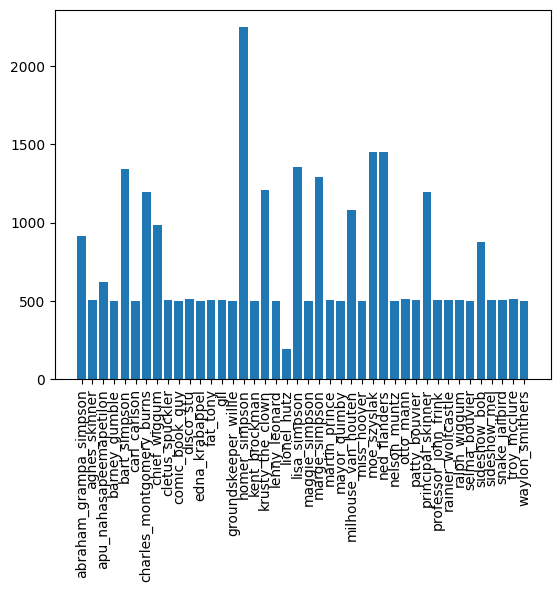

In [10]:
def print_classes_plot(directory):
    """
    Shows plot of the number of items in classes.
    :param directory: parent directory of classes.
    :return: None
    """
    class_stat = items_per_class(directory)
    plt.bar(class_stat.keys(), class_stat.values(), align='center')
    plt.xticks(rotation=90)
    print(f"Total classes: {len(class_stat.keys())}")
    print(f"Items per class:")
    for key, value in class_stat.items():
        print(key, value)
    plt.show()


print_classes_plot(train_dir)

In [11]:
def get_low_quality_classes(left, right):
    """
    Returns a list of classes which are left <= N <= right. Where N = number of items. 
    :param left: int
    :param right: int
    :return: list of classes
    """
    low_quantity_classes = []
    class_stat = items_per_class(train_dir)
    for key, value in class_stat.items():
        if left <= value <= right:
            low_quantity_classes.append(key)
            print(key, value)

    print(f"Classes with items [{left}:{right}] : {len(low_quantity_classes)}")
    print(low_quantity_classes)
    return low_quantity_classes

In [12]:
def remove_augmentations():
    """
    Removes "basic" augmentations from train dir
    :return: None
    """
    files_augmented = glob(os.path.join(train_dir, '*/aug*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))


def remove_random_augmentations():
    """
    Removes "random" augmentations from train dir
    :return: None
    """
    files_augmented = glob(os.path.join(train_dir, '*/random*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))

# remove_augmentations()
# remove_random_augmentations()

In [13]:


def apply_basic_aug():
    """
    Применение "базовой" аугментации к классу.
    (1) размытие по гауссу с ядром (25, 25)
    (2) Горизонтальный флип.
    
    Функция делает из 3 фото 12 штук. Нужна чтобы раздуть классы с очень маленькой численностью.
    (1) 3 базовых => 3 базовых + 3 размытых
    (2) 3 базовых 3 размытых => 3 базовых 3 размытых + 3 флипнутые базовые 3 флипнутые размытые 
    """
    blur_transform = transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0))
    flip_transform = transforms.RandomHorizontalFlip(p=1)

    classes = get_low_quality_classes(0, 30)

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            blurred = blur_transform(image)
            blurred.save(path)
            pic_number += 1
    print(f"blurred")

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            flipped = flip_transform(image)
            flipped.save(path)
            pic_number += 1
    print(f"flipped")


apply_basic_aug()

Classes with items [0:30] : 0
[]


0it [00:00, ?it/s]


blurred


0it [00:00, ?it/s]

flipped


In [14]:
# Применяем автоматическую аугментацию
classes = get_low_quality_classes(0, 500)
if len(classes) == 1:
    classes = []
for class_name in classes:
    dir_path = os.path.join(train_dir, class_name)
    pictures = glob(os.path.join(dir_path, '*'))
    pic_number = len(pictures)
    aug_per_pic = math.ceil((500 - pic_number) / pic_number)
    random_augment_transform = transforms.Compose([transforms.PILToTensor(),
                                                   transforms.RandAugment(num_ops=aug_per_pic + 2),
                                                   transforms.ToPILImage()])
    # Максимально возможное количество операций аугментации для каждого класса - 15 на каждую картинку
    if aug_per_pic > 15:
        aug_per_pic = 15
    rand = transforms.RandAugment(num_ops=aug_per_pic + 2)
    for filename in tqdm(pictures):
        image = Image.open(filename)
        for i in range(aug_per_pic):
            path = os.path.join(dir_path, f"random_aug_pic{pic_number}.png")
            augmented = rand(image)
            augmented.save(path)
            pic_number += 1
        if pic_number > 500:
            break

lionel_hutz 192
Classes with items [0:500] : 1
['lionel_hutz']


Total classes: 42
Items per class:
abraham_grampa_simpson 913
agnes_skinner 504
apu_nahasapeemapetilon 623
barney_gumble 502
bart_simpson 1342
carl_carlson 503
charles_montgomery_burns 1193
chief_wiggum 986
cletus_spuckler 506
comic_book_guy 501
disco_stu 512
edna_krabappel 501
fat_tony 504
gil 504
groundskeeper_willie 501
homer_simpson 2246
kent_brockman 501
krusty_the_clown 1206
lenny_leonard 501
lionel_hutz 192
lisa_simpson 1354
maggie_simpson 503
marge_simpson 1291
martin_prince 505
mayor_quimby 501
milhouse_van_houten 1079
miss_hoover 502
moe_szyslak 1452
ned_flanders 1454
nelson_muntz 501
otto_mann 512
patty_bouvier 504
principal_skinner 1194
professor_john_frink 505
rainier_wolfcastle 506
ralph_wiggum 504
selma_bouvier 503
sideshow_bob 877
sideshow_mel 508
snake_jailbird 505
troy_mcclure 512
waylon_smithers 502


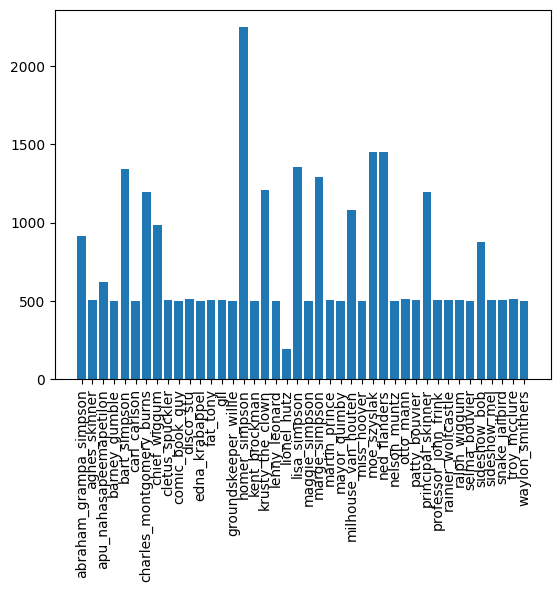

In [15]:
print_classes_plot(train_dir)

# 2. Работа с моделью.

#### Импортируем необходимые библиотеки

In [16]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets

In [17]:
num_epochs = 300
learning_rate = 0.001
batch_size = 16
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
images_dataset = datasets.ImageFolder(root=train_dir, transform=transforms.Compose([transforms.Resize((256, 256)),
                                                                                    transforms.CenterCrop(224), transforms.ToTensor()]))
images_dataset.idx_to_class = {v: k for k, v in images_dataset.class_to_idx.items()}

In [19]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split


def get_loaders(dataset, train_size=0.9):
    """
    Splits train dataset to train and validation samples.
    Returns loaders.
    :param dataset: 
    :param train_size: The size of the training sample relative to the source data
    :return: (train_loader, validation_loader) - tuple
    """
    length = len(dataset)
    indices = list(range(length))
    train_ind, val_ind = train_test_split(indices, train_size=train_size, stratify=dataset.targets, shuffle=True, random_state=42)
    train_sampler = SubsetRandomSampler(train_ind)
    valid_sampler = SubsetRandomSampler(val_ind)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, validation_loader


In [20]:
train_loader, validation_loader = get_loaders(images_dataset)

#### Подсчет среднего и стандартного отклонения тренировочной выборки.

In [21]:
def calculate_mean_std(loader):
    """
    Calculate the mean and std of the images
    :param indices: train indices of dataset images
    :return: (mean, std) - tuple
    """
    print('==> Computing mean and std..')

    total_sum = torch.tensor([0.0, 0.0, 0.0])
    total_sum_square = torch.tensor([0.0, 0.0, 0.0])

    for inputs, labels in tqdm(loader):
        total_sum += inputs.sum(axis=[0, 2, 3])
        total_sum_square += (inputs ** 2).sum(axis=[0, 2, 3])

    # len(df) = Number of images in dataset (df)
    image_size = 224
    count = len(loader) * loader.batch_size * image_size * image_size

    # mean and std
    total_mean = total_sum / count
    total_var = (total_sum_square / count) - (total_mean ** 2)
    total_std = torch.sqrt(total_var)
    # output
    print(f'mean: {total_mean}')
    print(f'std:  {total_std}')
    return total_mean, total_std

In [22]:
# dataset_mean, dataset_std = calculate_mean_std(train_loader)
dataset_mean = torch.tensor([0.4492, 0.4071, 0.3481])
dataset_std = torch.tensor([0.2709, 0.2514, 0.2729])

In [23]:
# Добавляем нормализацию к трансформации датасета
dataset_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize(mean=dataset_mean, std=dataset_std)])
images_dataset.transform = dataset_transform
images_dataset.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4492, 0.4071, 0.3481]), std=tensor([0.2709, 0.2514, 0.2729]))
)

In [24]:
test_dataset = datasets.ImageFolder(
    root=test_dir, transform=dataset_transform
)
test_dataset.idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}
test_dataset.idx_to_class

{0: 'abraham_grampa_simpson',
 1: 'apu_nahasapeemapetilon',
 2: 'bart_simpson',
 3: 'charles_montgomery_burns',
 4: 'chief_wiggum',
 5: 'comic_book_guy',
 6: 'edna_krabappel',
 7: 'homer_simpson',
 8: 'kent_brockman',
 9: 'krusty_the_clown',
 10: 'lenny_leonard',
 11: 'lisa_simpson',
 12: 'marge_simpson',
 13: 'mayor_quimby',
 14: 'milhouse_van_houten',
 15: 'moe_szyslak',
 16: 'ned_flanders',
 17: 'nelson_muntz',
 18: 'principal_skinner',
 19: 'sideshow_bob'}

In [25]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

#### Инициализируем модель

In [26]:
model = torchvision.models.resnet50(weights=None)
model_filename = "tb_model.pth"
if model_filename in os.listdir():
    model.load_state_dict(torch.load(model_filename, map_location=torch.device(device)))

In [27]:
inputs, classes = next(iter(train_loader))
writer.add_graph(model, inputs)

In [28]:
model = model.to(device)

In [29]:
writer.close()

In [30]:
# минимальная потеря на валидации
min_valid_loss = np.inf

# Определяем функцию потери
criterion = torch.nn.CrossEntropyLoss()

# Определяем оптимайзер
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Обучение модели

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def train():
    # Train the model...
    global min_valid_loss
    for epoch in range(num_epochs):
        print(f"Running {epoch + 1} epoch")
        train_loss = 0.0
        model.train()
        y_pred = []
        y_true = []
        for inputs, labels in tqdm(train_loader, mininterval=1):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item() * inputs.size(0)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
        precision = precision_score(y_true=y_true, y_pred=y_pred, average="macro")
        recall = recall_score(y_true=y_true, y_pred=y_pred, average="macro")
        f1 = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
        writer.add_scalar("train loss", train_loss / len(train_loader), epoch + 1)
        writer.add_scalar("train accuracy", accuracy, epoch + 1)
        writer.add_scalar("train precision", precision, epoch + 1)
        writer.add_scalar("train recall", recall, epoch + 1)
        writer.add_scalar("train f1", f1, epoch + 1)
        valid_loss = 0.0
        y_pred = []
        y_true = []
        model.eval()
        for inputs, labels in tqdm(validation_loader, mininterval=1):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
        precision = precision_score(y_true=y_true, y_pred=y_pred, average="macro")
        recall = recall_score(y_true=y_true, y_pred=y_pred, average="macro")
        f1 = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
        writer.add_scalar("validation loss", valid_loss / len(validation_loader), epoch + 1)
        writer.add_scalar("validation accuracy", accuracy, epoch + 1)
        writer.add_scalar("validation precision", precision, epoch + 1)
        writer.add_scalar("validation recall", recall, epoch + 1)
        writer.add_scalar("validation f1", f1, epoch + 1)
        print(
            f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_filename)

In [32]:
train()

Running 1 epoch


100%|██████████| 1745/1745 [10:06<00:00,  2.88it/s]
C:\Users\79137\PycharmProjects\Simpsons\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 194/194 [00:47<00:00,  4.11it/s]
C:\Users\79137\PycharmProjects\Simpsons\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 		 Training Loss: 53.98189522188509 		 Validation Loss: 40.91976902411156
Validation Loss Decreased(inf--->7938.435191) 	 Saving The Model
Running 2 epoch


100%|██████████| 194/194 [00:39<00:00,  4.96it/s]
C:\Users\79137\PycharmProjects\Simpsons\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 		 Training Loss: 34.98105706717701 		 Validation Loss: 28.9441643547766
Validation Loss Decreased(7938.435191--->5615.167885) 	 Saving The Model
Running 3 epoch


100%|██████████| 194/194 [00:38<00:00,  5.00it/s]


Epoch 3 		 Training Loss: 25.19293747344468 		 Validation Loss: 22.642055626997013
Validation Loss Decreased(5615.167885--->4392.558792) 	 Saving The Model
Running 4 epoch


100%|██████████| 194/194 [00:39<00:00,  4.97it/s]


Epoch 4 		 Training Loss: 19.84134632311441 		 Validation Loss: 19.02942914077916
Validation Loss Decreased(4392.558792--->3691.709253) 	 Saving The Model
Running 5 epoch


100%|██████████| 194/194 [00:38<00:00,  5.08it/s]


Epoch 5 		 Training Loss: 16.264416205780552 		 Validation Loss: 15.287406019636036
Validation Loss Decreased(3691.709253--->2965.756768) 	 Saving The Model
Running 6 epoch


100%|██████████| 194/194 [00:38<00:00,  5.01it/s]


Epoch 6 		 Training Loss: 13.421113185469263 		 Validation Loss: 13.734526781691718
Validation Loss Decreased(2965.756768--->2664.498196) 	 Saving The Model
Running 7 epoch


100%|██████████| 194/194 [00:38<00:00,  4.99it/s]


Epoch 7 		 Training Loss: 11.359131608924756 		 Validation Loss: 13.812604658382455
Running 8 epoch


100%|██████████| 194/194 [00:42<00:00,  4.52it/s]


Epoch 8 		 Training Loss: 9.603809219052252 		 Validation Loss: 12.334684939114089
Validation Loss Decreased(2664.498196--->2392.928878) 	 Saving The Model
Running 9 epoch


100%|██████████| 194/194 [00:38<00:00,  5.01it/s]


Epoch 9 		 Training Loss: 7.9281339771084935 		 Validation Loss: 13.473326059653587
Running 10 epoch


100%|██████████| 194/194 [00:39<00:00,  4.92it/s]


Epoch 10 		 Training Loss: 6.779244018386633 		 Validation Loss: 12.039113087445191
Validation Loss Decreased(2392.928878--->2335.587939) 	 Saving The Model
Running 11 epoch


100%|██████████| 194/194 [00:41<00:00,  4.73it/s]


Epoch 11 		 Training Loss: 5.551188356136866 		 Validation Loss: 10.751663455874034
Validation Loss Decreased(2335.587939--->2085.822710) 	 Saving The Model
Running 12 epoch


100%|██████████| 194/194 [00:43<00:00,  4.46it/s]


Epoch 12 		 Training Loss: 4.506889315820526 		 Validation Loss: 10.605573783599839
Validation Loss Decreased(2085.822710--->2057.481314) 	 Saving The Model
Running 13 epoch


100%|██████████| 194/194 [00:37<00:00,  5.16it/s]


Epoch 13 		 Training Loss: 3.8461368016802564 		 Validation Loss: 11.28365582335241
Running 14 epoch


100%|██████████| 194/194 [00:38<00:00,  4.98it/s]


Epoch 14 		 Training Loss: 2.7865299741548077 		 Validation Loss: 10.696727493681859
Running 15 epoch


 49%|████▉     | 852/1745 [06:49<07:09,  2.08it/s]


KeyboardInterrupt: 

#### Прогон модели на тестовых данных

In [33]:
torch.save(optimizer.state_dict(), "sgt_optimizer.pth")

In [ ]:
print_classes_plot(test_dir)

In [34]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        class_names = [test_dataset.idx_to_class[int(idx)] for idx in labels]
        # y_true.extend([images_dataset.class_to_idx[name] for name in class_names])
        y_true.extend(class_names)
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        outputs = outputs
        _, predicted = torch.max(outputs, 1)
        # y_pred.extend(predicted.cpu().numpy())
        y_pred.extend([images_dataset.idx_to_class[idx] for idx in predicted.cpu().numpy()])


100%|██████████| 60/60 [00:07<00:00,  7.79it/s]


In [35]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred, labels=test_dataset.classes)

C:\Users\79137\AppData\Local\Temp\ipykernel_14448\3451426370.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dataset.classes)
C:\Users\79137\AppData\Local\Temp\ipykernel_14448\3451426370.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(test_dataset.classes)


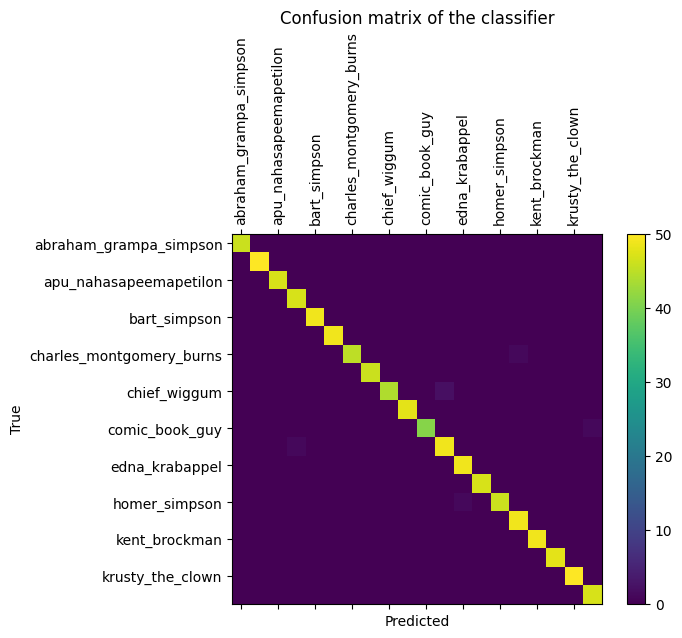

In [36]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(test_dataset.classes)
ax.set_yticklabels(test_dataset.classes)
ax.yaxis.set_major_locator(MaxNLocator(prune='both'))
ax.xaxis.set_major_locator(MaxNLocator(prune='both'))
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
from sklearn.metrics import multilabel_confusion_matrix

multi_cf = multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred, labels=images_dataset.classes)

![title](https://pythonru.com/wp-content/uploads/2021/03/matrica-oshibok-dlya-binarnoj-klassifikacii-1024x576.png)


In [38]:

for class_name in images_dataset.classes:
    idx = images_dataset.class_to_idx[class_name]
    class_cf = np.flip(multi_cf[idx])
    if class_name not in test_dataset.classes:
        continue
    tp = class_cf[0][0]
    fn = class_cf[0][1]
    fp = class_cf[1][0]
    tn = class_cf[1][1]
    total = class_cf.sum()
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(class_name)
    print(f"accuracy: {round(accuracy, 4)} \t\t precision: {round(precision, 4)} \t\t recall: {round(recall, 4)} \t\t f1: {round(f1, 4)}\n")

abraham_grampa_simpson
accuracy: 1.0 		 precision: 1.0 		 recall: 1.0 		 f1: 1.0

apu_nahasapeemapetilon
accuracy: 1.0 		 precision: 1.0 		 recall: 1.0 		 f1: 1.0

bart_simpson
accuracy: 1.0 		 precision: 1.0 		 recall: 1.0 		 f1: 1.0

charles_montgomery_burns
accuracy: 0.999 		 precision: 0.9792 		 recall: 1.0 		 f1: 0.9895

chief_wiggum
accuracy: 1.0 		 precision: 1.0 		 recall: 1.0 		 f1: 1.0

comic_book_guy
accuracy: 1.0 		 precision: 1.0 		 recall: 1.0 		 f1: 1.0

edna_krabappel
accuracy: 0.999 		 precision: 1.0 		 recall: 0.9783 		 f1: 0.989

homer_simpson
accuracy: 0.999 		 precision: 1.0 		 recall: 0.9787 		 f1: 0.9892

kent_brockman
accuracy: 0.9969 		 precision: 1.0 		 recall: 0.9362 		 f1: 0.967

krusty_the_clown
accuracy: 1.0 		 precision: 1.0 		 recall: 1.0 		 f1: 1.0

lenny_leonard
accuracy: 0.999 		 precision: 1.0 		 recall: 0.9762 		 f1: 0.988

lisa_simpson
accuracy: 0.9969 		 precision: 0.9608 		 recall: 0.98 		 f1: 0.9703

marge_simpson
accuracy: 0.9979 		 precision: 

In [43]:
print("===TEST===")
print(f"accuracy: {accuracy_score(y_true=y_true, y_pred=y_pred)}")
print(f"macro precision_score: {precision_score(y_true=y_true, y_pred=y_pred, average='macro')}")
print(f"macro recall_score: {recall_score(y_true=y_true, y_pred=y_pred, average='macro')}")
print(f"macro f1_score: {f1_score(y_true=y_true, y_pred=y_pred, average='macro')}")


===TEST===
accuracy: 0.9905759162303664
macro precision_score: 0.903596256684492
macro recall_score: 0.9003667439560131
macro f1_score: 0.9018924443159908


C:\Users\79137\PycharmProjects\Simpsons\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
writer.close()